In [2]:
%load_ext autoreload
%autoreload 2

from functools import reduce
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient
from smartenergy.database import MinuteMeasurements, HourlyMeasurements, Performance
from smartenergy.ml_service.features import BatteryStateFeatures, BasicPreprocessor, DateFeatures, DataGrouper, Pipeline

from IPython.core.display import display, HTML
from jupyterthemes import jtplot
jtplot.style('onedork')

np.warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
display(HTML("<style>.container { width: 1600px !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
## Check if station 311 has a battery
hourly_measurements = HourlyMeasurements()
data = hourly_measurements.load_single_station('311')

In [10]:
data.head()

""


In [ ]:
## Exploring volt data

minute_measurements = MinuteMeasurements()
stations = minute_measurements.station_ids[:2]
data = {
    'MinuteMeasurements': minute_measurements.load_multiple_stations(stations, 1000),
}
print(data['MinuteMeasurements'].shape)
data['MinuteMeasurements'].sample(5)



In [ ]:
vars_ = ['fVPV_avg', 'fVGrid_avg', 'fVBattery_avg']
for v in vars_:
    data['MinuteMeasurements'][v] = data['MinuteMeasurements'][v].astype(str).apply(lambda x: x.replace(',', '.')).astype(float)

data['MinuteMeasurements'].groupby('solbox_id')[vars_].agg(['mean', 'std', 'min', 'max'])

In [30]:
performance = Performance()
performance_data = pd.DataFrame(performance.load_all()).set_index('t').sort_index()

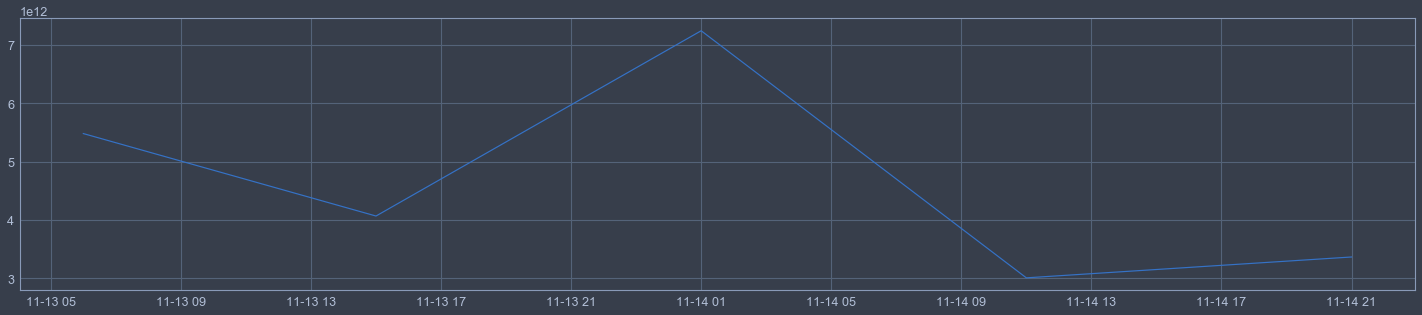

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(performance_data['agent_service'].index, performance_data['agent_service'].values)
plt.show()

In [29]:
performance_data.index

DatetimeIndex(['2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00'],
              dtype='datetime64[ns]', name='t', freq=None)

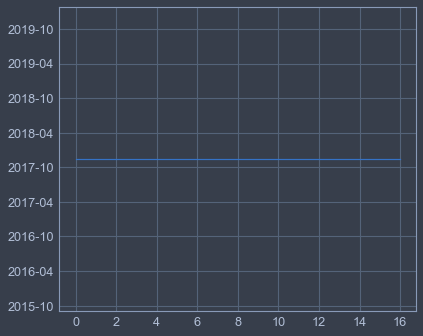

In [27]:
plt.plot(performance_data['agent_service'].index, performance_data['agent_service'].values)

In [26]:
performance_data['agent_service'].values

array([5.13644534e+12, 2.26450919e+12, 3.02878111e+12, 5.02673179e+12,
       4.30569921e+12, 8.85555148e+12, 4.94094778e+12, 5.69522468e+12,
       1.33101755e+12, 4.09708423e+12, 5.23346798e+12, 5.59566291e+12,
       5.75356744e+12, 3.39032592e+12, 3.40464003e+12, 2.95212443e+12,
       3.04631644e+12])

In [25]:
performance_data['agent_service'].index

DatetimeIndex(['2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00', '2017-11-13 06:00:00',
               '2017-11-13 06:00:00'],
              dtype='datetime64[ns]', name='t', freq=None)

In [22]:
performance_data

,_id,agent_service,forecast_service
t,,,
2017-11-13 06:00:00,5bbc97540d850e37f4942a2c,5136445341696.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc976d0d850e37f4942aa5,2264509186048.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc977b0d850e37f4942b1e,3028781105152.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc97890d850e37f4942b97,5026731786240.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc97970d850e37f4942c10,4305699209216.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc97a50d850e37f4942c89,8855551475712.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc97b30d850e37f4942d02,4940947783680.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc97c10d850e37f4942d7b,5695224676352.00,{'XGBoostHourlyGenerationStationPredictor': {'...
2017-11-13 06:00:00,5bbc97d00d850e37f4942df4,1331017547776.00,{'XGBoostHourlyGenerationStationPredictor': {'...


In [21]:
performance_data['agent_service']

t
2017-11-13 06:00:00   5136445341696.00
2017-11-13 06:00:00   2264509186048.00
2017-11-13 06:00:00   3028781105152.00
2017-11-13 06:00:00   5026731786240.00
2017-11-13 06:00:00   4305699209216.00
2017-11-13 06:00:00   8855551475712.00
2017-11-13 06:00:00   4940947783680.00
2017-11-13 06:00:00   5695224676352.00
2017-11-13 06:00:00   1331017547776.00
2017-11-13 06:00:00   4097084227584.00
2017-11-13 06:00:00   5233467981824.00
2017-11-13 06:00:00   5595662909440.00
2017-11-13 06:00:00   5753567444992.00
2017-11-13 06:00:00   3390325915648.00
2017-11-13 06:00:00   3404640026624.00
2017-11-13 06:00:00   2952124432384.00
2017-11-13 06:00:00   3046316441600.00
Name: agent_service, dtype: float64